# Question 1

Equation for simple harmonic oscillator:

$$ m\ddot{x} = -k (x-x_{\text{eq}})$$

where $m$ is mass, $k$ is the spring constant and $x_{\text{eq}}$ is the equilibrium position. For this exercise, these parameters are all set to unity.
The analytic solution is found using the solution to a general 2nd order linear DE, first for the homogeneous part and then for the particular part:

$$x(t) = x_h(t) + x_p(t)$$

where $x_h(t)$ is determined by substituting $x=e^{r\omega t}$ and $x_p(t)$ uses the test solution $x_p(t) = Ax^2 + Bx + C$. For the homogeneous solution, substituting it yields:
$$mr^2 + k = 0$$
with roots $\omega = \pm i\sqrt{k/m}$, giving the homogeneous solution: $x_h(t) = c_1 \sin(\omega t)+c_2 \cos(\omega t)$. Substituting the particular solution yields $x_p(t) = {x_{\text{eq}}}/{k}$. The constants are then found to be: $c_1= v_0 / \omega$ and $c_2 = x_0 - x_{\text{eq}}$. The values of $x_0 = x(0)$ and $v_0 = \dot{x}(0)$ are the initial conditions. Thus:

$$ x(t) = \frac{v_0}{\omega} \sin(\omega t)+(x_0 - x_{\text{eq}}) \cos(\omega t) + x_{\text{eq}} $$

In [1]:
import numpy as np

MASS = 1.
SPRING_K = 1.
X_EQ = 1.

# Get the force corresponding to the equation of motion,
# which is a simple harmonic oscillator.
def F_SHO(x):
    return -SPRING_K * (x - X_EQ)

def SHO_x_sol(x0, v0, t):
    omega = np.sqrt(SPRING_K / MASS)
    b = x0 - X_EQ
    a = v0 / omega
    return a * np.sin(omega * t) + b * np.cos(omega * t) + X_EQ / SPRING_K

def SHO_v_sol(x0, v0, t):
    omega = np.sqrt(SPRING_K / MASS)
    b = x0 - X_EQ
    a = v0 / omega
    return a * omega * np.cos(omega * t) - b * omega * np.sin(omega * t)


# Forward Euler integration scheme, getting the position and 
# velocity values at the next time index using step size dt
def forward_euler_general(F_func, x, v, dt):
    F = F_func(x)
    x2 = x + dt * v + (F * dt**2) / (2 * MASS)
    v2 = v + (F * dt) / MASS
    return x2, v2

# Verlet integration scheme, getting the position and 
# velocity values at the next time index using step size dt
def verlet_general(F_func, x_, x, dt):
    F = F_func(x)
    x2 = 2. * x - x_ + (F * dt**2) / MASS
    return x2

# Verlet integration scheme, getting the position and 
# velocity values at the next time index using step size dt
def v_verlet_general(F_func, x, v, dt):
    F = F_func(x)
    vh = v + (F * dt) / (2. * MASS)
    x2 = x + vh * dt
    v2 = vh + (F_func(x2) * dt) / (2. * MASS)
    return x2, v2


def forward_euler(x, v, dt):
    return forward_euler_general(F_SHO, x, v, dt)

def verlet(x_, x, dt):
    return verlet_general(F_SHO, x_, x, dt)

def v_verlet(x, v, dt):
    return v_verlet_general(F_SHO, x, v, dt)



In [2]:
# Question 1 data

import matplotlib.pyplot as plt

NUM_SAMPLES = 10
END_TIME = 20.

DT_START = 1
DT_END = 0.2
NUM_DT = 3


# Initial conditions
x = np.full(NUM_SAMPLES, X_EQ)
v = np.sin(np.linspace(0, 2 * np.pi, NUM_SAMPLES))
v0 = 1

# Samples of dt to test
dts = np.linspace(DT_START, DT_END, NUM_DT)

# Position and velocity for each dt and for each result
xr, vr = np.tile(x, (NUM_DT, 4, 1)), np.tile(v, (NUM_DT, 4, 1))

# Position and velocity for a sample where time evolution is tracked
xe = np.zeros((NUM_DT, 3, int(END_TIME / DT_END + 2)))
ve = xe.copy()

# Initial conditions of the tracked sample
x0 = X_EQ
v0 = 1
for n in range(0, NUM_DT):
    for i in range(0, 3):
        xe[n][i][0] = x0
        ve[n][i][0] = v0
        

j = 0
for n in range(0, NUM_DT):
    xs = xr[n]
    vs = vr[n]
    dt = dts[n]
    steps = END_TIME / dt + 1
    
    x_ = xs[1].copy()
    ts = np.linspace(0., END_TIME, int(steps))
    for t in ts:
        
        xe[n][0][j + 1], ve[n][0][j + 1] = forward_euler(xe[n][0][j], ve[n][0][j], dt)
        xe[n][2][j + 1], ve[n][2][j + 1] = v_verlet(xe[n][2][j], ve[n][2][j], dt)
        
        if t == 0:
            xe[n][1][j + 1], ve[n][1][j + 1] = xe[n][0][j + 1].copy(), ve[n][0][j + 1].copy()
        else:
            xe[n][1][j + 1] = verlet(xe[n][1][j - 1], xe[n][1][j], dt)
            ve[n][1][j] = (xe[n][1][j + 1] - xe[n][1][j - 1]) / (2 * dt)
            
        j += 1
        
        xs[0], vs[0] = forward_euler(xs[0], vs[0], dt)
        xs[2], vs[2] = v_verlet(xs[2], vs[2], dt)
        
        
        # the first step for the Verlet integrator comes from the
        # Forward Euler solver
        if t == 0:
            xs[1], vs[1] = xs[0].copy(), vs[0].copy()
        else:
            tmp = xs[1].copy()     # save the current time step
            xs[1] = verlet(x_, xs[1], dt)
            vs[1] = (xs[1] - x_) / (2 * dt)
            x_ = tmp.copy()
    
    j = 0
    
    # align the time index for the x solution from the
    # verlet method with known velocity
    xs[1] = x_
    
    # evaluate the analytic solution
    xs[3] = SHO_x_sol(x, v, END_TIME)
    vs[3] = SHO_v_sol(x, v, END_TIME)  

## Final Position for Different Initial Velocities

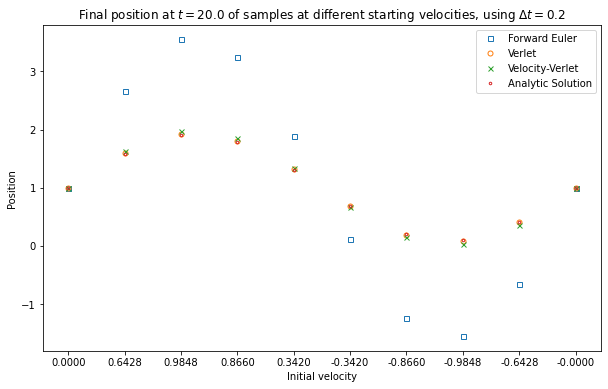

In [3]:
# Question 1 plot: amplitude

labels = ["Forward Euler", "Verlet", "Velocity-Verlet", "Analytic Solution"]
markers = ["s", "o", "x", "."]


DT_N = -1

plt.figure(figsize=(10,6))

for i in range(0, 4):
    plt.plot(xr[DT_N][i], 
             label="{}".format(labels[i]), 
             marker=markers[i], 
             markerfacecolor="None",
             markersize=5,
             linestyle="None")

plt.legend()
plt.xticks(np.arange(NUM_SAMPLES), ["{:.4f}".format(e) for e in v])
plt.xlabel("Initial velocity")
plt.ylabel("Position")
plt.title("Final position at $t={}$ of samples at different starting velocities, using $\Delta t={}$".format(END_TIME, dts[DT_N]))
plt.show()

## Time Evolution of Amplitude for $x_0 = x_{\text{eq}}$ and $v_0 = 1$

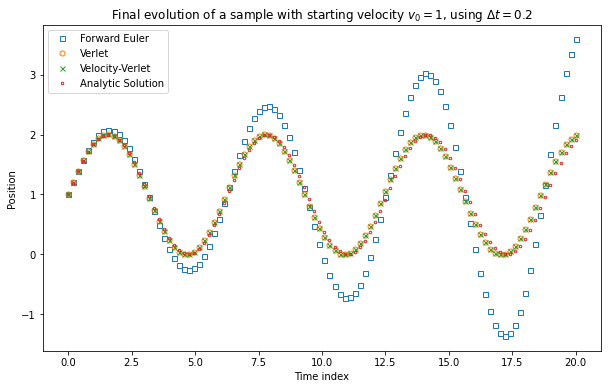

In [4]:
ts = np.linspace(0., END_TIME, len(xe[DT_N][0]))

plt.figure(figsize=(10,6))

for i in range(0, 3):
    plt.plot(ts, xe[DT_N][i],
             label="{}".format(labels[i]), 
             marker=markers[i], 
             markerfacecolor="None",
             markersize=5,
             linestyle="None")

plt.plot(ts, SHO_x_sol(x0, v0, ts),
         label="{}".format(labels[3]), 
         marker=markers[3], 
         markerfacecolor="None",
         markersize=5,
         linestyle="None")

plt.legend()
plt.xticks()
plt.xlabel("Time index")
plt.ylabel("Position")
plt.title("Final evolution of a sample with starting velocity $v_0 = 1$, using $\Delta t={}$".format(DT_END))
plt.show()

## Position-Momentum Phase Diagram of a Sample in Time

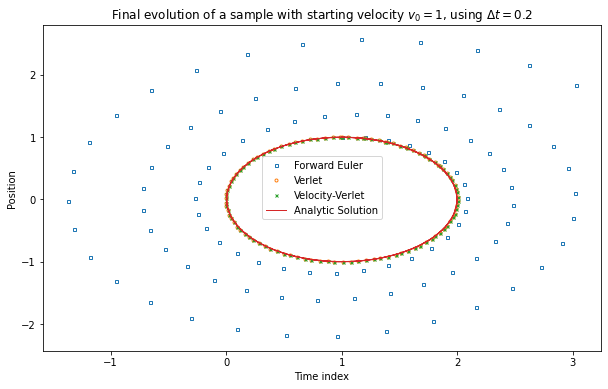

In [5]:
ts = np.linspace(0., END_TIME, len(xe[DT_N][0]))

plt.figure(figsize=(10,6))

# When plotting, remove last point since for regular Verlet
# method, the 
for i in range(0, 3):
    plt.plot(xe[DT_N][i][0:-2], ve[DT_N][i][0:-2],
             label="{}".format(labels[i]), 
             marker=markers[i], 
             markerfacecolor="None",
             markersize=3,
             linestyle="None")

plt.plot(SHO_x_sol(x0, v0, ts), SHO_v_sol(x0, v0, ts),
         label="{}".format(labels[3]), 
         markerfacecolor="None",
         linewidth="1",
         linestyle="-")

plt.legend()
plt.xticks()
plt.xlabel("Time index")
plt.ylabel("Position")
plt.title("Final evolution of a sample with starting velocity $v_0 = 1$, using $\Delta t={}$".format(DT_END))
plt.show()

## Interpretation

The phase diagram of the velocity-momentum solutions shows the difference in behaviour of the numerical solution. Since the Forward-Euler method doesn't conserve energy, the amplitude increases unboundedly. This is in contrast to the Verlet methods, which are energy-conserving methods and ensures that the trajectory in phase-space does not leave the contour line it startedin.

In general, based on the time evolution plot, as well as the first plot comparing the solutions for different initial velocities, shows that the Verlet methods produce data in close correspondence with analytic results.

# Question 2

## Lennard-Jones potential

In [50]:

eps = 1.
sigma = 1.

max_F = 1e2

def U_LJ(r):
    x, y = tuple(r.T)
    
    sigma2 = sigma * sigma
    s_r2 = sigma2 / (np.power(x, 2) + np.power(y, 2))
    s_r6 = np.power(s_r2, 3)
    s_r12 = np.power(s_r2, 6)
    
    return (4. * eps) * (s_r12 - s_r6)

def F_LJ(r):
    x, y = tuple(r.T)
    
    r2 = np.power(x, 2) + np.power(y, 2)
    #eps = np.full(np.shape(r2), 1)
    #r2 = np.maximum(r2, eps)
    
    sigma2 = sigma * sigma
    r8 = np.power(r2, 4)
    s_r8 = np.power(r2 / sigma2, -4)
    s_r14 = np.power(r2 / sigma2, -7)
    
    F = (48. * eps / sigma2) * (s_r14 - 0.5 * s_r8)
    #mask = F > max_F
    #F[mask] = max_F
    #Fx = F * x
    #Fy = F * y
    #Fx[mask] = max_F / x[mask]
    #Fy[mask] = max_F / y[mask]
    #cutoff = np.full(np.shape(x), max_F)
    #print(np.minimum(F * x, cutoff))
    #return np.array([*zip(np.minimum(F * x, cutoff), np.minimum(F * y, cutoff))])
    return np.array([F * x, F * y]).T

def F_LJx(x):
    
    sigma2 = sigma * sigma
    s_r2 = sigma2 / (x * x)
    s_r8 = np.power(s_r2, 4)
    s_r14 = np.power(s_r2, 7)
    
    F = (48. * eps / sigma2) * (s_r14 - 0.5 * s_r8)
    cutoff = np.full(np.shape(x), max_F)
    return np.minimum(F * x, cutoff)

# Forward Euler integration scheme, getting the position and 
# velocity values at the next time index using step size dt
def forward_euler_LJ(r, v, dt):
    return forward_euler_general(F_LJ, r, v, dt)

# Verlet integration scheme, getting the position and 
# velocity values at the next time index using step size dt
def verlet_LJ(r_, r, dt):
    return verlet_general(F_LJ, r_, r, dt)

# Verlet integration scheme, getting the position and 
# velocity values at the next time index using step size dt
def v_verlet_LJ(r, v, dt):
    return v_verlet_general(F_LJ, r, v, dt)


In [60]:

%matplotlib widget

import importlib

import boxgen
from boxgen import BOX_DIMENSIONS as dims
importlib.reload(boxgen)

# compute all the displacements and velocities caused by the
# other particles on this one
def compute_displacements(rs, vs, i1, i2=None):
    
    cutoff = dims[0] / 2
    
    if i2 == None:
        i = i1
        
        N = np.size(rs, 1)
        drs = np.zeros((3, N, 2))
        dvs = np.zeros((3, N, 2))
        for n in range(0, 3):
            rx1, ry1 = rs[n][i]
            vx1, vy1 = vs[n][i]
            
            for j in range(i + 1, N):
                rx2, ry2 = rs[n][j]
                drx = rx2 - rx1
                dry = ry2 - ry1
                
                pdx = drx - dims[0] * round(drx / dims[0], 0)
                pdy = dry - dims[1] * round(dry / dims[1], 0)
                
                if pdx * pdx + pdy * pdy < cutoff * cutoff:
                    vx2, vy2 = vs[n][j]
                    dvx = vx2 - vx1
                    dvy = vy2 - vy1
                    
                    drs[n][j] = (pdx, pdy)
                    dvs[n][j] = (dvx, dvy)
            return drs, dvs
    
    else:
        i = i1
        j = i2
        
        drs = np.zeros((3, 2))
        dvs = np.zeros((3, 2))
        
        for n in range(0, 3):
            rx1, ry1 = rs[n][i]
            vx1, vy1 = vs[n][i]
            rx2, ry2 = rs[n][j]
            vx2, vy2 = vs[n][j]
            
            drx = rx2 - rx1
            dry = ry2 - ry1
            
            pdx = drx - dims[0] * round(drx / dims[0], 0)
            pdy = dry - dims[1] * round(dry / dims[1], 0)
            
            if pdx * pdx + pdy * pdy < cutoff * cutoff:
                dvx = vx2 - vx1
                dvy = vy2 - vy1
                
                drs[n] = (pdx, pdy)
                dvs[n] = (dvx, dvy)
                
        return drs, dvs

def solve_system(rs, vs, dt):
    N = np.size(rs, 1)
    steps = END_TIME / dt + 1
    ts = np.linspace(0., END_TIME, int(steps))
    
    positions = np.empty((int(steps), 3, N, 2))
    velocities = np.empty((int(steps), 3, N, 2))
    ind = 0
    
    
    _drs = np.empty((N, N, 2))
    for t in ts:

        for i in range(0, N):
            
            if False:
                drs, dvs = compute_displacements(rs, vs, i)
                
                mask = np.empty((3, N), dtype=bool)
                for n in range(0, 3):
                    x, y = tuple(drs[n].T)
                    mask[n] = (x * x + y * y > 0)
                    
                dr2s = np.empty((3, N, 2))
                dv2s = np.empty((3, N, 2))
                
                dr2s[0], dv2s[0] = forward_euler_LJ(drs[0], dvs[0], dt)
                dr2s[2], dv2s[2] = v_verlet_LJ(drs[2], dvs[2], dt)
                
                if t > 0:
                    dr2s[1] = verlet_LJ(_drs[i], drs[1], dt)
                    dv2s[1] = (dr2s[1] - _drs[i,j]) / (2 * dt)
                else:
                    dr2s[1] = dr2s[0].copy()

                
                _drs[i] = drs[1].copy()
                drs -= dr2s
                dvs -= dv2s
                
                delta_r = np.zeros((3, N, 2))
                delta_v = np.zeros((3, N, 2))
                for n in range(0, 3):
                    x, y = tuple(drs[n].T)

                    #rx, ry = tuple(dr2s[n].T)
                    #vx, vy = tuple(dv2s[n].T)
                    
                    delta_r[n][mask[n]] += -drs[n][mask[n]] / 2
                    delta_v[n][mask[n]] += -dvs[n][mask[n]] / 2
                    delta_r[n][i] += np.sum(drs[n][mask[n]]) / 2
                    delta_v[n][i] += np.sum(dvs[n][mask[n]]) / 2
                    
                for n in range(0, 3):
                    for j in range(0, N):
                        rs[n][j] += delta_r[n][j] 
                        vs[n][j] += delta_v[n][j] 
            else:
                for j in range(i + 1, N):
                    drs, dvs = compute_displacements(rs, vs, i, j)
                    dr2s = np.empty((3, 2))
                    dv2s = np.empty((3, 2))
                    
                    dr2s[0], dv2s[0] = forward_euler_LJ(drs[0], dvs[0], dt)
                    dr2s[2], dv2s[2] = v_verlet_LJ(drs[2], dvs[2], dt)
                    
                    if t > 0:
                        dr2s[1] = verlet_LJ(_drs[i,j], drs[1], dt)
                        dv2s[1] = (dr2s[1] - _drs[i,j]) / (2 * dt)
                    else:
                        dr2s[1] = dr2s[0].copy()

                    
                    _drs[i,j] = drs[1].copy()
                    
                    for n in range(0, 3):
                        x, y = drs[n]
                        if x * x + y * y > 0:
                            dr = drs[n] - dr2s[n]
                            dv = dvs[n] - dv2s[n]
                            rs[n][i] += -dr / 2
                            vs[n][i] += -dv / 2
                            rs[n][j] += dr / 2
                            vs[n][j] += dv / 2
                
        
            
        
        rs -= dims[0] * ((rs / dims[0]) // 1)
        #for n in range(0, 3):
        #    for i in range(0, N):
        #        rs[n][i][0] -= dims[0] * ((rs[n][i][0] / dims[0]) // 1)
        #        rs[n][i][1] -= dims[1] * ((rs[n][i][1] / dims[1]) // 1)
               
                
        positions[ind] = rs
        velocities[ind] = vs
        ind += 1
        
    return positions, velocities

In [78]:
import random
import math
import matplotlib.animation as animation

END_TIME = 8
NUM_REMOVE = 2

#pos0 = np.array(dims)
#pos1 = np.array([0, dims[0]])
#particles = np.array([pos0 / 2, pos0 / 4, pos0 / 3, pos1 / 2, pos1])

particles = np.array(boxgen.generate_lattice(False))

# remove `NUM_REMOVE` random particles
dels = sorted(np.random.randint(0, len(particles), NUM_REMOVE))
mask = np.ones(len(particles), dtype=bool)
mask[dels] = False

r0 = particles[mask]
#r0 = np.random.rand(5, 2)
r0 *= dims[0]
v0 = np.random.normal(size=(len(r0), 2))

dts = [0.001]
rs = np.tile(r0, (len(dts), 3, 1, 1))
vs = np.tile(v0, (len(dts), 3, 1, 1))

#print(rs[0][2])

for n in range(0, len(dts)):
    dt = dts[n]
    positions, velocities = solve_system(rs[n], vs[n], dt)
    
    
solver_ind = 2

plt.close()
fig, ax = plt.subplots()
xs, ys = zip(*positions[0][solver_ind])
frame, = ax.plot(xs, ys, 'o')


plt.xlim(0, dims[0])
plt.ylim(0, dims[1])
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("Positions of particles in a box {}Å x {}Å".format(*dims))

def animate(i):
    xs, ys = zip(*positions[i][solver_ind])
    frame.set_data(xs, ys)
    return frame,

ani = animation.FuncAnimation(fig, animate, interval=10, repeat=False, blit=True, save_count=len(positions))

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

#dr = rs[0][S] - r0
#xs, ys = tuple(r0.T)
#dxs, dys = tuple(dr.T)
#N = np.size(r0, 0)
#print(N)


C:\Users\Zirconix\AppData\Local\Temp\ipykernel_16352\2153245463.py:25: RuntimeWarning: divide by zero encountered in power
  s_r8 = np.power(r2 / sigma2, -4)
C:\Users\Zirconix\AppData\Local\Temp\ipykernel_16352\2153245463.py:26: RuntimeWarning: divide by zero encountered in power
  s_r14 = np.power(r2 / sigma2, -7)
C:\Users\Zirconix\AppData\Local\Temp\ipykernel_16352\2153245463.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  F = (48. * eps / sigma2) * (s_r14 - 0.5 * s_r8)


## Interpretation of MD Simulation

### First Attempt

The MD simulations performed by the three integrators all appear unstable, as the velocity of the particles grow unboundedly until eventually the particles will just randomly jump around and invalidate the data. This occurs regardless of the time step as well. The primary reason behind this failure in the simulations appears to be that the particles approach each other too closely, called here "over-moved", and in doing so the repelling force is too strongly applied. This results in ever-increasing velocities, resuling in more over-moving until eventually the integrator breaks down. 

The velocity-Verlet integrator, although failing eventually, fails later than the other integrators. This implies that the simulation loop itself might be updating the positions in a somewhat incorrect way.

### Second Attempt

The update loop changed to deal with particle pairs one at a time. In the initial implementation, the whole system of displacements from a given particle was solved, all the changes in displacement were added together, and then the particle position was updated with this total change in position from all those interactions. The idea was that updating particles using the total interaction effectively resulted in the particle being over-moved and on the subsequent time step having a force applied to it that would incur an overly large velocity being.

It was found that regardless of this change, the particles would still ultimately begin moving too fast and result in the breakdown of the solution. However, the breakdown took much longer to happen with this more fine-grained approach of updating particle positions.

## Measurements

In [77]:
# Energy

CUTOFF_TIME = 5

N = np.size(positions, 2)
L = np.size(positions, 0)
ts = np.linspace(0., END_TIME, L)
dt = ts[1] - ts[0]

L = int(CUTOFF_TIME // dt)
ts = ts[0:L]

energy = np.zeros((3, L))
temp = np.zeros((3, L))
cutoff = dims[0] / 2

ind = 0
for velocity, position in zip(velocities, positions):
    for n in range(0, 3):
        for i in range(0, N):
            
            vx, vy = velocity[n][i]
            temp[n][ind] += 0.5 * MASS * (vx * vx + vy * vy)
            
            cx, cy = position[n][i]
            for j in range(i + 1, N):
                x, y = position[n][j]
                dx = cx - x
                dy = cy - y
                
                if not math.isnan(dx):
                    
                    pdx = dx - dims[0] * round(dx / dims[0])
                    pdy = dy - dims[1] * round(dy / dims[1])
                    
                    if pdx * pdx + pdy * pdy < cutoff * cutoff:
                        energy[n][ind] += 1
        temp[n][ind] *= (1 / N) 
    ind += 1
    
    



energy[1] = np.zeros(len(positions))
energy[2] = np.zeros(len(positions))

plt.clf()
solver_str = ["Forward-Euler", "Verlet", "Velocity-Verlet"]
for n in range(0, 3):
    plt.plot(ts, energy[n], linestyle=(2 * n, (8, 5, 1, 5)), linewidth=0.8, label="Energy of {} solver".format(solver_str[n]))

plt.title("Interaction energy")
plt.ylabel("Energy")
plt.xlable("Time")
plt.legend()
plt.show()

for n in range(0, 3):
    plt.plot(ts, temp[n], linestyle=(2 * n, (8, 5, 1, 5)), linewidth=0.8, label="Energy of {} solver".format(solver_str[n]))

plt.title("Average Kinetic Energy")
plt.ylabel("Energy")
plt.xlable("Time")
plt.legend()
plt.show()
            

NameError: name 'velocities' is not defined

# Extra

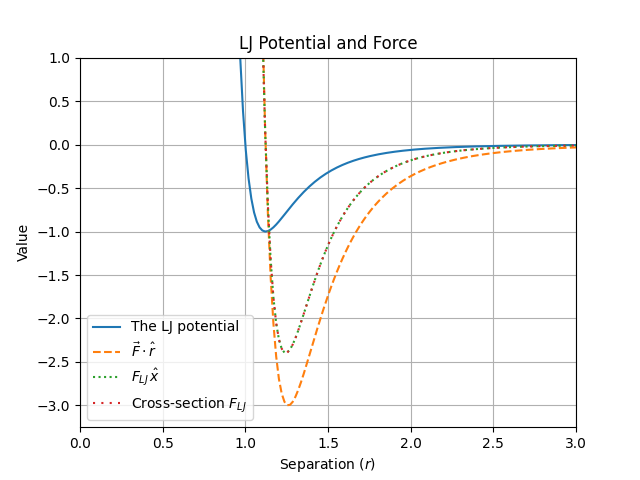

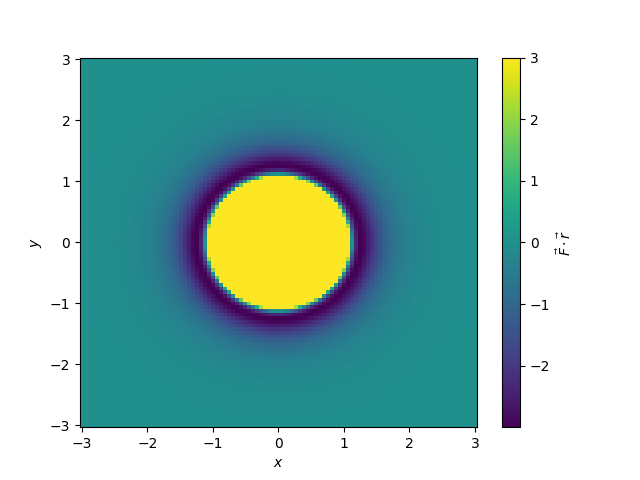

In [48]:
# Plot LJ Force and Potential

dd = np.linspace(.65, 3, 200)
r = np.stack((dd, dd), axis=1)
Fx, Fy = tuple(F_LJ(r).T)
x, y = tuple(r.T)

R = np.sqrt(x * x + y * y)

Fxx, _ = tuple(F_LJ(np.stack((R, np.zeros(len(dd))), axis=1)).T)

plt.clf()
plt.plot(R, U_LJ(r), label="{}".format("The LJ potential"))
plt.plot(R, (Fx * x + Fy * y), linestyle='dashed', label="{}".format("$\\vec{F} \cdot \\hat{r}$"))
plt.plot(R, F_LJx(R), linestyle='dotted', label="{}".format("$F_{LJ}\\,\\hat{x}$"))
plt.plot(R, Fxx, linestyle=(0, (1, 3)), label="{}".format("Cross-section $F_{LJ}$"))


plt.legend()
plt.xlim(0, 3)
plt.ylim(-3.25, 1)

plt.title("LJ Potential and Force")
plt.xlabel("Separation ($r$)")
plt.ylabel("Value")
plt.grid()
plt.show()

fig, ax = plt.subplots()
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xs, ys = np.meshgrid(x, y)

fz = np.zeros((len(x), len(y)))
for i in range(0, len(x)):
    for j in range(0, len(y)):
        r = np.array([[x[i], y[j]]])
        Fx, Fy = F_LJ(r)[0]
        F = Fx * x[i] + Fy * y[j]
        fz[i][j] = Fx * x[i] + Fy * y[j] if F < 3 else 3
            
        
#surf = ax.plot_surface(xs, ys, fz, linewidth=0, rcount=200, ccount=200)
#fig.colorbar(surf, shrink=0.5)
#ax.set_zlim(-3.25, 1)
#ax.imshow(fz, extent=[-3, 3, -3, 3])
c = ax.pcolormesh(xs, ys, fz, shading="auto")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
fig.colorbar(c, ax=ax, label="$\\vec{F} \cdot \\vec{r}$")

plt.show()